# Acá tenemos un a cosa que hay que referenciar !!
## Ajusta las adquisiciones "hot" y "cold" para calibrar los datos.
### siguiendo la metodología del libro Essential Radio Astronomy Chapter 3.6.6

In [ ]:
!pip install plot_params

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os, glob
import csv
import scipy as sp
from scipy.ndimage import median_filter
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun
from datetime import datetime
import pandas as pd
from scipy.ndimage.filters import uniform_filter1d
#import plot_params
%matplotlib inline

<ipython-input-6-a0e8d1d92f67>:12: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


In [ ]:
# function to read in all the files in a directory and calculate the average spectrum (counts at each frequency channel)
def avespec(directory):
    # get the list of all spectra (csv files) in directory
    files = glob.glob(directory + '/*.csv')
    # you can print out the result to make sure its doing the right thing
    #print(files)

    # read in the first file to initialize the sum
    nu0, C_sum = np.genfromtxt(files[0], delimiter=',', unpack=True)

    # loop through all the other files and sum the counts
    for f in files[1:]:
        nu1, C1 = np.genfromtxt(f, delimiter=',', unpack=True)
        if np.array_equal(nu0,nu1):
            C_sum += C1
        else:
            print('Error: frequency axes are different in avespec')
            return False, False

    # divide by the number of files to produce the average
    C_ave = C_sum / len(files)

    return nu0, C_ave

In [ ]:
# go to the data directory
path = '/content/drive/MyDrive/Python/example_data'
os.chdir(path)
filelist = os.listdir()
#print(filelist)

Text(0, 0.5, 'Counts')

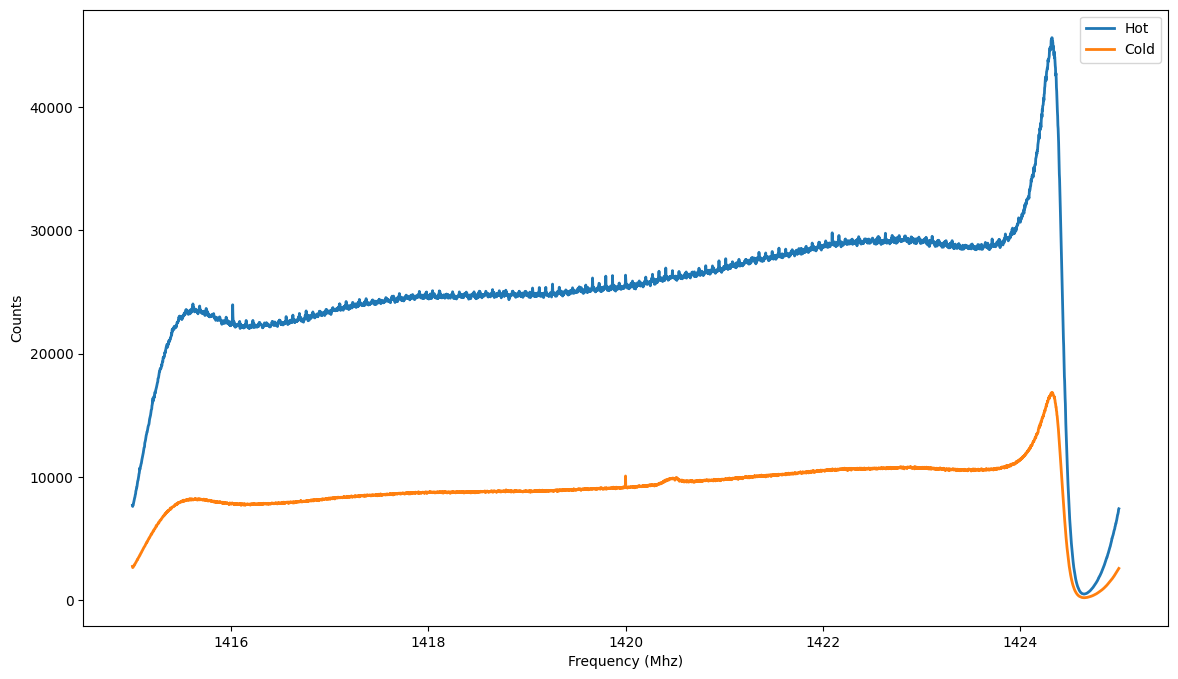

In [ ]:
# average the spectra in each of the hot and cold directories
nu_hot, Chot = avespec('hot')
nu_cold, Ccold = avespec('cold')

if np.array_equal(nu_hot,nu_cold):
    nu = nu_hot
else:
    print('Error: Hot and Cold frequency axes are different')

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
ax.plot(nu, Chot, label='Hot', lw=2)
ax.plot(nu, Ccold, label='Cold', lw=2)
ax.legend()
ax.set_xlabel('Frequency (Mhz)')
ax.set_ylabel('Counts')

# the hot load has some spikes to it - perhaps standing waves from pointing to the ground?
# (we'll ignore and proceed - its a small effect)

Text(0, 0.5, 'Chot / Ccold')

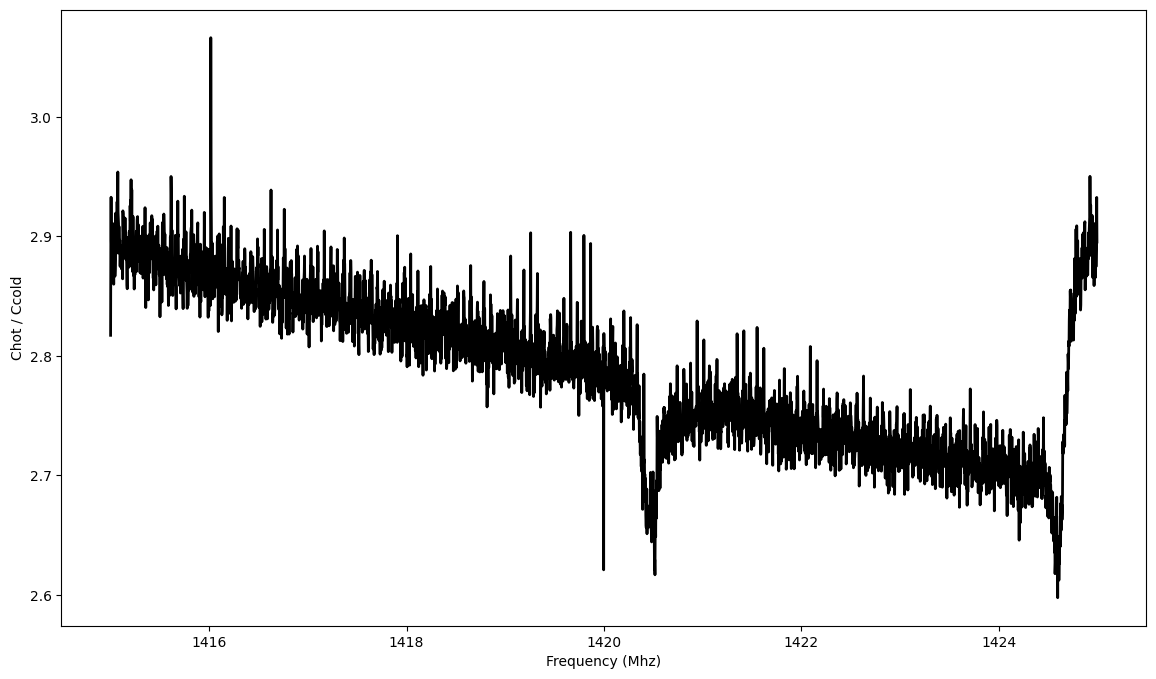

In [ ]:
# look at the hot / cold ratio
# should be fairly constant

Y = Chot / Ccold

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
ax.plot(nu, Y, lw=2, color='black')
ax.set_xlabel('Frequency (Mhz)')
ax.set_ylabel('Chot / Ccold')

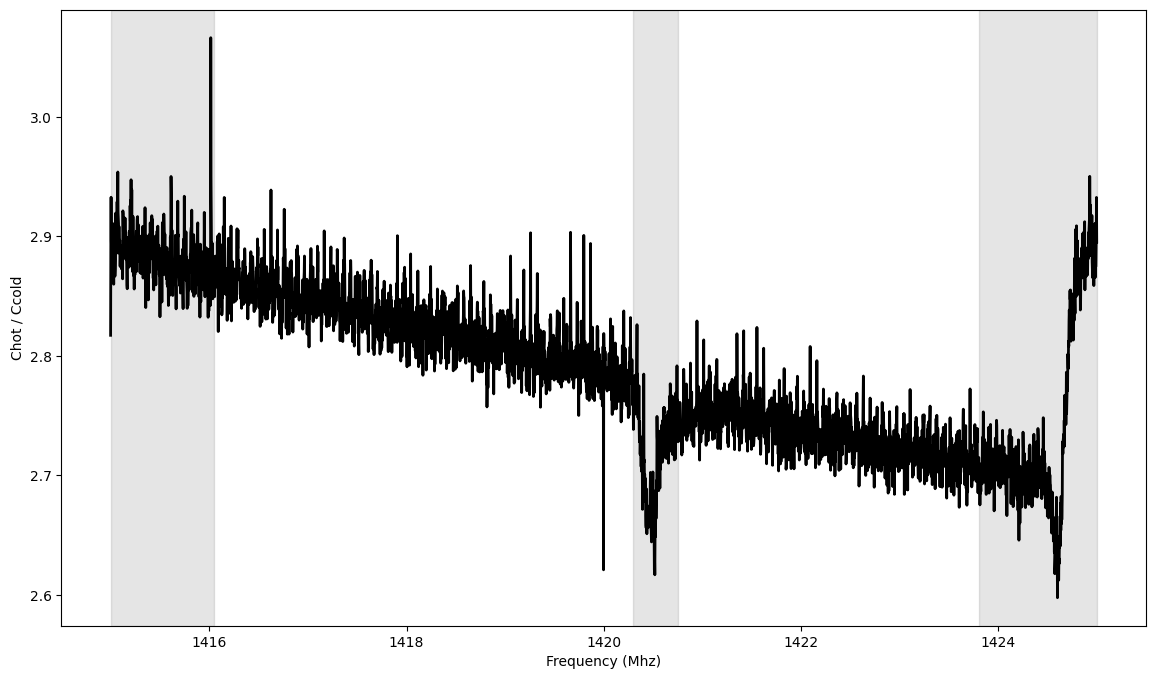

In [ ]:
# mask out the edges of the bandpass where the sensitivity drops
# and the HI line in the cold load
# this is user-defined (i.e., subjective) for now...

nu_edge1 = [1415.00, 1416.05]
nu_edge2 = [1423.80, 1425.00]
nu_coldline = [1420.30, 1420.75]

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
ax.plot(nu, Y, lw=2, color='black')
ax.set_xlabel('Frequency (Mhz)')
ax.set_ylabel('Chot / Ccold')

ax.axvspan(nu_edge1[0], nu_edge1[1], color='black', alpha=0.1)
ax.axvspan(nu_edge2[0], nu_edge2[1], color='black', alpha=0.1)
ax.axvspan(nu_coldline[0], nu_coldline[1], color='black', alpha=0.1)

Text(0, 0.5, 'Chot / Ccold')

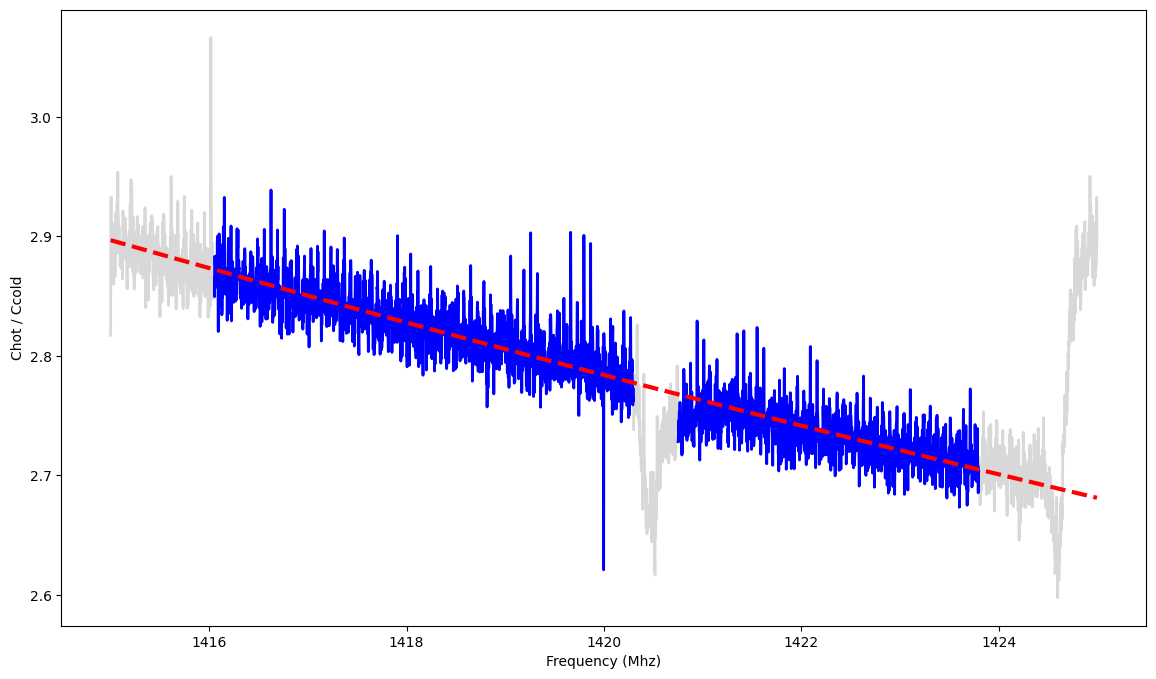

In [ ]:
# fit the ratio away from the HI line with a quadratic function

bad1 = nu < nu_edge1[1]
bad2 = (nu > nu_coldline[0]) & (nu < nu_coldline[1])
bad3 = nu > nu_edge2[0]
bad = bad1 + bad2 + bad3

good1 = (nu > nu_edge1[1]) & (nu < nu_coldline[0])
good2 = (nu > nu_coldline[1]) & (nu < nu_edge2[0])
good = good1 + good2

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
ax.plot(nu[bad1], Y[bad1], lw=2, color='gray', alpha=0.3)
ax.plot(nu[bad2], Y[bad2], lw=2, color='gray', alpha=0.3)
ax.plot(nu[bad3], Y[bad3], lw=2, color='gray', alpha=0.3)
ax.plot(nu[good1], Y[good1], lw=2, color='blue')
ax.plot(nu[good2], Y[good2], lw=2, color='blue')

order = 2
p = np.polyfit(nu[good], Y[good], order)
Yfit = np.poly1d(p)
ax.plot(nu, Yfit(nu), color='red', linestyle='--', lw=3)

ax.set_xlabel('Frequency (Mhz)')
ax.set_ylabel('Chot / Ccold')

Text(0, 0.5, 'Gain (Counts/K)')

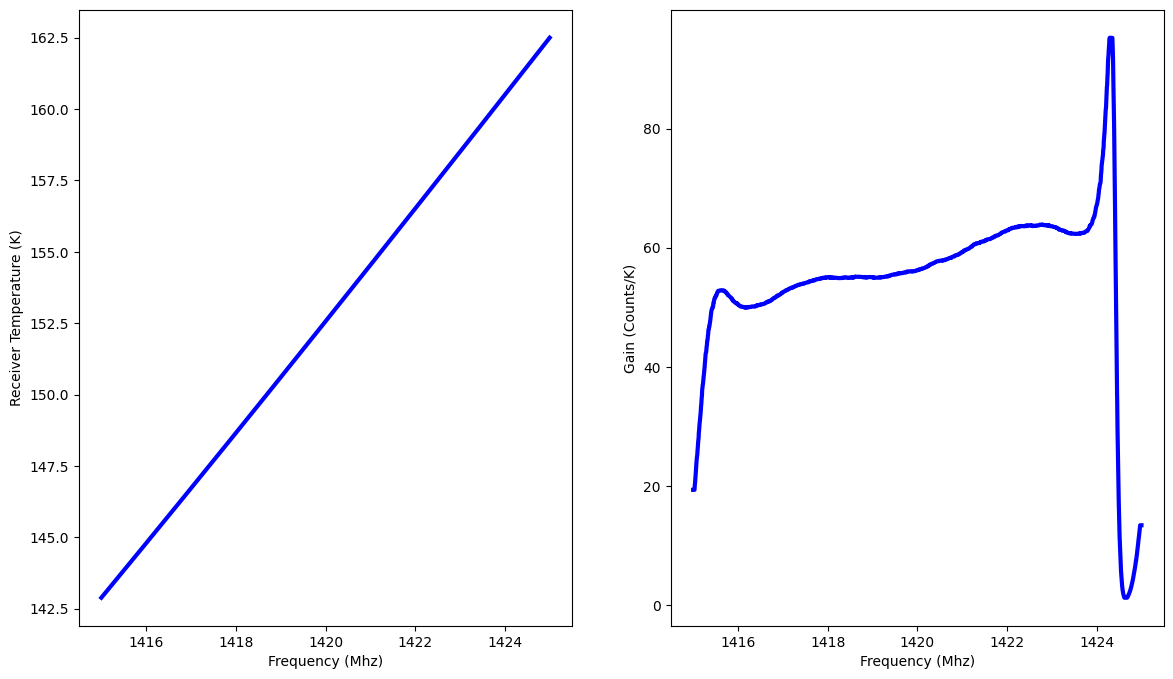

In [ ]:
# plot the receiver temperature and gain

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

Thot = 300
Tcold = 10
Tr = (Thot - Yfit(nu)*Tcold) / (Yfit(nu) - 1)
ax1.plot(nu, Tr, color='blue', linestyle='-', lw=3)
ax1.set_xlabel('Frequency (Mhz)')
ax1.set_ylabel('Receiver Temperature (K)')

G = Chot / (Thot + Tr)
# median filter the result as we do not need high frequency resolution to correct the data
G = median_filter(Chot, size=51) / (Thot + Tr)
ax2.plot(nu, G, color='blue', linestyle='-', lw=3)
ax2.set_xlabel('Frequency (Mhz)')
ax2.set_ylabel('Gain (Counts/K)')

# could trim off the edges
#ax2.set_xlim(nu_edge1[1], nu_edge2[0])

In [ ]:
import os
import csv

fname = '/content/drive/MyDrive/Python/calibration.csv'  # Use /content directory for writing files in Google Colab

if os.path.exists(fname):
    print('*** Calibration file already exists: ', fname)
    print('*** Delete this manually if you want to overwrite')
else:
    # zip the two arrays together so they write out as rows and reverse the order so v goes from low to high
    print('Writing calibration spectrum to ', fname)
    with open(fname, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(zip(nu, Tr, G))

Writing calibration spectrum to  /content/drive/MyDrive/Python/calibration.csv


In [ ]:
from google.colab import files

files.download(fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>